In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/Mask_RCNN'

/content/drive/.shortcut-targets-by-id/1xuo4FVROJBpOYQfz9QcDshp5kPAvpxB1/UBS-Auto_Server_Audit /mask-rcnn-tf2/Mask_RCNN


In [4]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0

     |████████████████████████████████| 462 kB 6.2 MB/s 


In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR =  '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/Mask_RCNN'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 



In [6]:
class NewConfig(Config):
    # Give the configuration a recognizable name
    NAME = "pmk222"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # # Use small images for faster training. Set the limits of the small side
    # # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # # Reduce training ROIs per image because the images are small and have
    # # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10#100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1#5
    
config = NewConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
import re
import cv2
from mrcnn.utils import Dataset
class PmkDataset(Dataset):
    """Configuration for training printer monitor keyboard detection on the dataset.
    Overrides values in the base Config class.
    """
    # extract bounding boxes from an annotation file
    def extract_boxes(self, file_path):
      boxes = list()
      with open(file_path) as f:
        data_list = f.read().split('\n')
        data_list = [d.split() for d in data_list if d]
        for data in data_list:
            name = ' '.join(data[:-4])
            xmin = int(float(data[-4]))
            ymin = int(float(data[-3]))
            xmax = int(float(data[-2]))
            ymax = int(float(data[-1]))
            coors = [xmin, ymin, xmax, ymax, name]
            if name=='Printer'or name=='Computer monitor' or name=='Computer keyboard':
                boxes.append(coors)
        img_path = re.sub('annot','img',file_path)
        img_path = re.sub('txt','jpg',img_path)
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        return boxes, width, height

    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "Printer")
        self.add_class("dataset", 2, "Computer monitor")
        self.add_class("dataset", 3, "Computer keyboard")
        images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_train/'
        annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_train/'
        for filename in os.listdir(images_dir):
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.txt'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=[0,1,2,3])#,2
    
    def load_val_dataset(self, dataset_dir, is_train=True): 
        self.add_class("dataset", 1, "Printer")
        self.add_class("dataset", 2, "Computer monitor")
        self.add_class("dataset", 3, "Computer keyboard")
        images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_test/'
        annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_test/'
        for filename in os.listdir(images_dir):
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.txt'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids=[0,1,2,3])#,2


    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (box[4] == 'Printer'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Printer'))
            elif (box[4] == 'Computer monitor'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Computer monitor')) 
            elif (box[4] == 'Computer keyboard'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Computer keyboard'))   
        return masks, np.asarray(class_ids, dtype='int32')  


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [9]:
# prepare train set
train_set = PmkDataset()
train_set.load_dataset('Printer')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = PmkDataset()
test_set.load_val_dataset('Printer')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 221
Test: 54


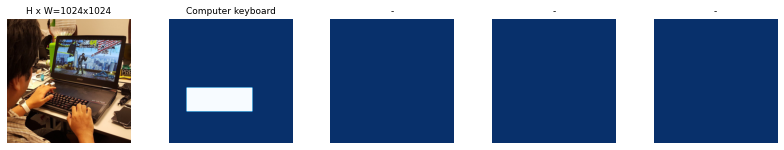

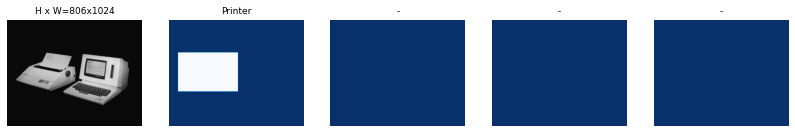

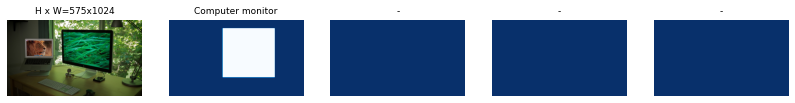

In [ ]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 3)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)



In [ ]:
MODEL_DIR = '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/weights_created'
COCO_MODEL_PATH = '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/Mask_RCNN/weights/mask_rcnn_coco.h5'

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/weights_created/pmk22220220330T0430/mask_rcnn_pmk222_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages

Epoch 1/10
10/10 [==============================] - 568s 56s/step - batch: 4.5000 - size: 1.0000 - loss: 15.6113 - rpn_class_loss: 1.8309 - rpn_bbox_loss: 10.2242 - mrcnn_class_loss: 1.3809 - mrcnn_bbox_loss: 1.8792 - mrcnn_mask_loss: 0.2960 - val_loss: 25.2354 - val_rpn_class_loss: 0.0295 - val_rpn_bbox_loss: 18.8878 - val_mrcnn_class_loss: 0.0568 - val_mrcnn_bbox_loss: 5.5714 - val_mrcnn_mask_loss: 0.6899
Epoch 2/10
10/10 [==============================] - 512s 52s/step - batch: 4.5000 - size: 1.0000 - loss: 11.3266 - rpn_class_loss: 0.2509 - rpn_bbox_loss: 6.2611 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 4.0575 - mrcnn_mask_loss: 0.5666 - val_loss: 47.4469 - val_rpn_class_loss: 5.7476 - val_rpn_bbox_loss: 41.6993 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 518s 52s/step - batch: 4.5000 - size: 1.0000 - loss: 16.4454 - rpn_class_loss: 1.5628 - rpn_bbox_loss: 9.6718 - mrc

In [11]:
MODEL_DIR = '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/weights_created/pmk22220220330T0430/'

class InferenceConfig(NewConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/weights_created/pmk22220220330T0430/mask_rcnn_pmk222_0010.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/weights_created/pmk22220220330T0430/mask_rcnn_pmk222_0010.h5
Re-starting from epoch 10


In [12]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

TypeError: ignored

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=get_ax())


NameError: ignored

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(test_set.image_ids, 10)
APs = []
for image_id in image_ids:  #test_set.image_ids
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

TypeError: ignored

In [ ]:
# evaluate the mask rcnn model on the kangaroo dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP


# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, inference_config)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, inference_config)
print("Test mAP: %.3f" % test_mAP)


In [ ]:
import pandas as pd
from mrcnn import utils
import numpy as np
import mrcnn.model as modellib

#########  Print confusion matrix for the whole dataset and return tp,fp and fn ##########
#########  The style of this confusion matrix is inspired from https://github.com/wcipriano/pretty-print-confusion-matrix ##########

from string import ascii_uppercase
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.collections import QuadMesh
from matplotlib import font_manager as fm

def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    sn.set(font_scale=1.8)
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)
    

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 26)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 26)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[36,36], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
        return the tp, fp and fn
    """

    #data
    if(not columns):
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:max(len(np.unique(y_test)),len(np.unique(predictions)))]]
    
    y_test = np.array(y_test)
    predictions = np.array(predictions)
    #confusion matrix 
    confm = confusion_matrix(y_test, predictions)
    num_classes = len(columns)
    
    #compute tp fn fp 
    
    fp=[0]*num_classes
    fn=[0]*num_classes
    tp=[0]*num_classes
    for i in range(confm.shape[0]):
        fn[i]+=np.sum(confm[i])-np.diag(confm)[i]
        fp[i]+=np.sum(np.transpose(confm)[i])-np.diag(confm)[i]
        for j in range(confm.shape[1]):
            if i==j:
                tp[i]+=confm[i][j]
    
    #plot
    df_cm = DataFrame(confm, index=columns, columns=columns)

    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, 
        pred_val_axis=pred_val_axis, lw=lw, fmt=fmt)
    
    return tp, fp, fn

total_gt = np.array([]) 
total_pred = np.array([]) 

for image_id in test_set.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(test_set, config, image_id)#, #use_mini_mask=False)
    info = test_set.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    total_gt = np.append(total_gt, gt)
    total_pred = np.append(total_pred, pred)

total_gt=total_gt.astype(int)
total_pred=total_pred.astype(int)

tp,fp,fn=plot_confusion_matrix_from_data(total_gt,total_pred,fz=18, 
                                         figsize=(20,20), lw=0.5)



In [ ]:
#add save images in dir

import skimage
from mrcnn.visualize import display_instances
base_path = '/content/drive/MyDrive/UBS-Auto_Server_Audit /sneha notebooks/pmk images/'
results_dir = '/content/drive/MyDrive/UBS-Auto_Server_Audit /mask-rcnn-tf2/result_images_created'
for i in listdir(base_path):
    img_path = base_path + i
    image = skimage.io.imread(img_path)
    print(image)
    print(type(image))
    print(image.shape)
    image_name = img_path.split("/")[-1]
    r = model.detect([image], verbose=1)[0]
    save_img_path = results_dir + i
    display_instances(image, r['rois'], r['masks'], r['class_ids'], ['no data',"printer","computer monitor", "computer keyboard"], r['scores'])